# Evaluación de modelos

## Ejecución

En principio solo modificar la variable `model_name` con el nombre del modelo que generó los resultados, y las celdas **Input** de cada problema de clasificación para almacenar los resultados en los correspondientes `y_true`, `y_pred` e `y_proba`.  

Tener en cuenta que para `y_proba` se espera que mediante la expresión
```python
y_proba["y_proba_i"]
```
se pueda acceder a la lista de probabilidades asignadas a la clase $i$ de todas las instancias.

## Notas

Hay métricas de las decisiones (clase predicha), y métricas de los scores (probabilidades asignadas por clase)
 
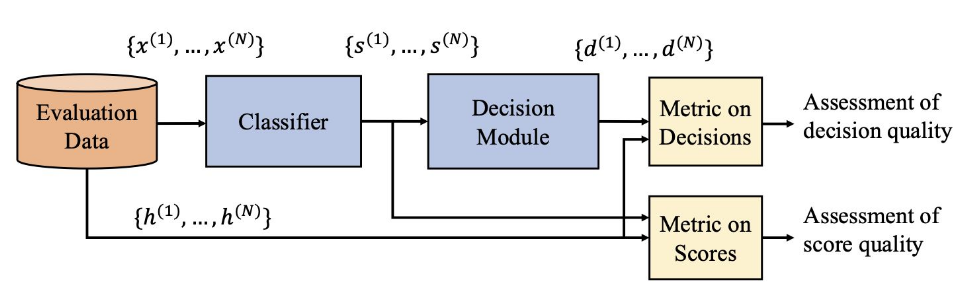

Cálculo de Balanced Accuracy ([fuente](https://arxiv.org/pdf/2008.05756))

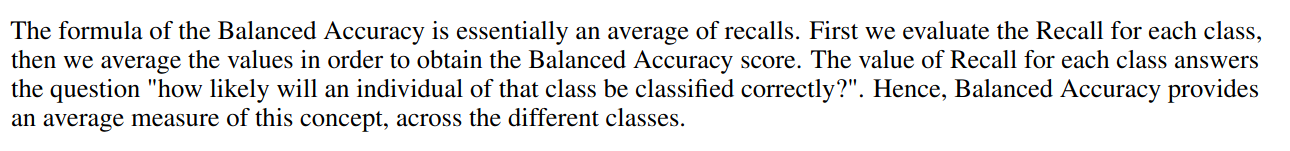

## Funciones auxiliares

### Imports

In [92]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, average_precision_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import log_loss


### Configuración de almacenamiento de resultados

In [93]:
model_name = "RF" # <---------- MODIFICAR PARA QUE SE CORRESPONDA COM MODELO QUE SE ESTÁ EVALUANDO!
results_dir = "plots/evaluation/"

### Matriz de Confusión

In [94]:
def generate_confusion_matrix(y_true, y_pred, classes: list[str], plot_title: str, store_path: str):
  """
  Calcula matriz de confusión para y_true e y_pred, la grafica usando como labels las clases de "classses" y como título a "plot_title".
  El gráfico se almacena en results_dir (variable global).
  """
  
  n_classes = len(classes)
  labels = np.arange(n_classes)
  
  cm = confusion_matrix(y_true, y_pred, labels=labels)
  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

  fig, ax = plt.subplots()
  cm_display.plot(cmap="Reds", values_format="d", ax=ax)

  plt.title(plot_title)
  plt.savefig(store_path)
  plt.show()

  return cm


### Métricas - Decisiones

In [95]:
def generate_decision_metrics(confusion_matrix, classes: list[str], store_path: str):
  """
  Dada una matriz de confusión, calcula métricas de decisión y las almacena en un txt. 
  Imprime en pantalla lo almacenado.
  """
  n_predictions = np.sum(confusion_matrix)
  n_classes = len(classes)

  # Métricas x clase a calcular
  recall = np.zeros(n_classes)
  precision = np.zeros(n_classes)
  fpr = np.zeros(n_classes)
  F1 = np.zeros(n_classes)
  TP_total = 0

  for i in range(n_classes): 
    # Extrayendo TP, FN, FP y TN de la clase
    TP = confusion_matrix[i, i]
    FN = sum(confusion_matrix[i, :]) - TP
    FP = sum(confusion_matrix[:, i]) - TP
    TN = n_predictions - (TP + FN + FP)

    # Calcular métricas de la clase
    recall[i] = TP / (TP + FP)
    precision[i] = TP / (TP + FN)
    fpr[i] = FP / (FP + TN)
    F1[i] = 2 * precision[i] * recall[i] / (precision[i] + recall[i])
    TP_total += TP

  # F1 macro - promedio de los F1 x clase
  F1_macro = F1.mean()

  # Accuracy global
  accuracy = TP_total / n_predictions

  # Balanced accuracy
  balanced_accuracy = recall.mean()

  # Store metrics
  with open(store_path, "w") as file:
    for i, class_name in enumerate(classes):  file.write(f"Recall {class_name}: {recall[i]}\n")
    file.write("\n")
    for i, class_name in enumerate(classes): file.write(f"Precision {class_name}: {precision[i]}\n")
    file.write("\n")
    for i, class_name in enumerate(classes): file.write(f"FPR {class_name}: {fpr[i]}\n")
    file.write("\n")
    for i, class_name in enumerate(classes): file.write(f"F1 {class_name}: {F1[i]}\n")
    file.write("\n")
    file.write(f"F1 Macro: {F1_macro}\n")
    file.write(f"Accuracy: {accuracy}\n")
    file.write(f"Balanced Accuracy: {balanced_accuracy}\n")

  # Print metrics
  with open(store_path, "r") as file:
    print(file.read())

### Métricas - Scores

In [96]:
def generate_scores_metrics(y_true, y_proba, classes: list[str], store_path: str):
  """
  Calcula métricas de score para y_true e y_proba, independientemente de la cantidad de clases. 
  Almacena los resultados en un txt y los imprime en pantalla.
  """

  n_classes = len(classes)

  # Métricas por clase a calcular
  auc_roc_score_ovr = np.zeros(n_classes)
  average_precision_score_ovr = np.zeros(n_classes)
  for i in range(n_classes): 
    # Métricas One-vs-Rest. Se toma una clase como positiva y al resto como negativas.
    y_true_ovr = y_true == i
    y_proba_ovr = y_proba[f"y_proba_{i}"]

    auc_roc_score_ovr[i] = roc_auc_score(y_true_ovr, y_proba_ovr)
    average_precision_score_ovr[i] = average_precision_score(y_true_ovr, y_proba_ovr)

  # Métricas OvR macro, revisar si esto sirve
  auc_roc_score_ovr_macro = auc_roc_score_ovr.mean()
  average_precision_score_ovr_macro = average_precision_score_ovr.mean()

  # Cross Entropy/Log Loss
  cross_entropy = log_loss(y_true, y_proba)

  # Store metrics
  with open(store_path, "w") as file:
    for i, class_name in enumerate(classes):  file.write(f"AUC ROC OvR {class_name}: {auc_roc_score_ovr[i]}\n")
    file.write("\n")
    for i, class_name in enumerate(classes): file.write(f"Average Precision OvR {class_name}: {average_precision_score_ovr[i]}\n")
    file.write("\n")
    file.write(f"Cross Entropy: {cross_entropy}\n")
    file.write(f"AUC ROC OvR Macro: {auc_roc_score_ovr_macro}\n")
    file.write(f"Average Precision Macro: {average_precision_score_ovr_macro}\n")

  # Print metrics
  with open(store_path, "r") as file:
    print(file.read())

### Gráficos

In [97]:
def graficar_roc_curves(y_true, y_proba, classes, title='Curvas ROC OvR', save_path=None, threshold_mark=None, ax=None):
  # Gráfico base
  show=False
  if ax is None:
    show = True
    fig, ax = plt.subplots()
  ax.plot([0, 1], [0, 1], 'k--', label='Random')
  ax.set_xlabel('FPR')
  ax.set_ylabel('TPR')
  ax.set_title(title)
  
  # Curva y label por clase
  for i, classname in enumerate(classes): 
    # Métricas One-vs-Rest. Se toma una clase como positiva y al resto como negativas.
    y_true_ovr = y_true == i
    y_proba_ovr = y_proba[f"y_proba_{i}"]

    score = roc_auc_score(y_true_ovr, y_proba_ovr)
    fpr, tpr, thresholds = roc_curve(y_true_ovr, y_proba_ovr)

    ax.plot(fpr, tpr, label=f'{classname} (AUC = {score:.2f})')

    if threshold_mark is not None:
        idx = (np.abs(thresholds - threshold_mark)).argmin()
        ax.scatter(fpr[idx], tpr[idx], color="red", s=80, label=f'Threshold={threshold_mark:.2f}')

    
  ax.legend()

  if save_path:
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
  if show:
    plt.show()




def graficar_precision_recall_curve(y_true, y_proba, classes, title='Precision-Recall Curve', save_path=None, ax=None):
  # Gráfico base
  show=False
  if ax is None:
    show = True
    fig, ax = plt.subplots()
  ax.set_xlabel('Recall')
  ax.set_ylabel('Precision')
  ax.set_title(title)

  # Curva y label por clase
  for i, classname in enumerate(classes): 
    # Métricas One-vs-Rest. Se toma una clase como positiva y al resto como negativas.
    y_true_ovr = y_true == i
    y_proba_ovr = y_proba[f"y_proba_{i}"]
    
    score = average_precision_score(y_true_ovr, y_proba_ovr)
    precision, recall, thresholds = precision_recall_curve(y_true_ovr, y_proba_ovr)
    ax.plot(recall, precision, label=f'{classname} (AUC = {score:.2f})')

  ax.legend()
  if save_path:
    plt.savefig(save_path)
  if show:
    plt.show()




## Capitalización 

### Input

In [98]:
df_test_cap = pd.read_csv('../data/processed/test_cap_rf_p.csv')

y_test_true_cap = df_test_cap["y_cap"]
y_test_pred_cap = df_test_cap["y_pred"]
y_test_proba_cap = df_test_cap[["y_proba_0", "y_proba_1", "y_proba_2", "y_proba_3"]] 

classes_cap = ['0 hola', '1 Hola', '2 iPhone', '3 UBA']
df_test_cap

,position,token_len,emb_norm,dist_prev,dist_next,is_subword,token_first_char,y_cap,y_pred,y_proba_0,y_proba_1,y_proba_2,y_proba_3
0,0,5,1.154769,0.000000,1.552196,0,101,1,1,1.00,0.00,0.00,0.00
1,1,3,1.228544,1.552196,1.845347,0,110,0,0,1.00,0.00,0.00,0.00
2,2,7,1.530294,1.845347,1.933306,1,111,0,0,0.48,0.52,0.00,0.00
3,3,1,1.034368,1.933306,1.733397,0,99,0,0,0.91,0.00,0.09,0.00
4,4,6,1.400558,1.733397,1.751145,1,114,0,0,0.97,0.03,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795263,25,6,1.213995,1.651150,1.542552,1,105,0,0,0.84,0.16,0.00,0.00
795264,26,2,1.019073,1.542552,1.083699,0,101,0,0,1.00,0.00,0.00,0.00
795265,27,2,1.062491,1.083699,1.703159,0,101,0,0,1.00,0.00,0.00,0.00
795266,28,7,1.367896,1.703159,1.728870,0,105,0,0,0.97,0.02,0.01,0.00


### Matriz de confusión

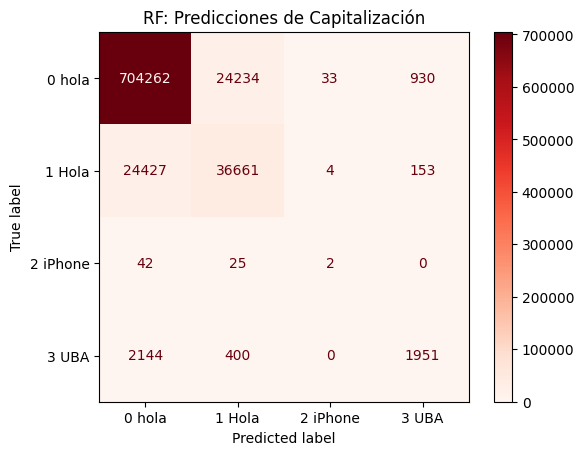

In [99]:
cm_cap = generate_confusion_matrix(
  y_test_true_cap, y_test_pred_cap, classes_cap, f"{model_name}: Predicciones de Capitalización",
  f"{results_dir}{model_name}_cap_confusion_matrix.png"  
)

### Métricas - Decisiones

In [100]:
generate_decision_metrics(cm_cap, classes_cap, f"{results_dir}{model_name}_cap_decision_metrics.txt")

Recall 0 hola: 0.9635874807593637
Recall 1 Hola: 0.5978636660143509
Recall 2 iPhone: 0.05128205128205128
Recall 3 UBA: 0.6430454845088991

Precision 0 hola: 0.9654579626819327
Precision 1 Hola: 0.5985958037390807
Precision 2 iPhone: 0.028985507246376812
Precision 3 UBA: 0.4340378197997775

FPR 0 hola: 0.40439757479979943
FPR 1 Hola: 0.033594315164511196
FPR 2 iPhone: 4.652923356291947e-05
FPR 3 UBA: 0.0013695460011912395

F1 0 hola: 0.964521814872488
F1 1 Hola: 0.5982295108717822
F1 2 iPhone: 0.037037037037037035
F1 3 UBA: 0.5182627174923629

F1 Macro: 0.5295127700684175
Accuracy: 0.9341203217028725
Balanced Accuracy: 0.5639446706411663



### Métricas - Scores

In [101]:
generate_scores_metrics(y_test_true_cap, y_test_proba_cap, classes_cap, f"{results_dir}{model_name}_cap_scores_metrics.txt")

AUC ROC OvR 0 hola: 0.4543750867822041
AUC ROC OvR 1 Hola: 0.4856209339972954
AUC ROC OvR 2 iPhone: 0.5473124483232535
AUC ROC OvR 3 UBA: 0.42714471284006167

Average Precision OvR 0 hola: 0.9082524395936584
Average Precision OvR 1 Hola: 0.08886983410518506
Average Precision OvR 2 iPhone: 0.00010112767023613175
Average Precision OvR 3 UBA: 0.005443640088965062

Cross Entropy: 2.43832051331846
AUC ROC OvR Macro: 0.4786132954857037
Average Precision Macro: 0.2506667603645112



## Puntuación inicial 

### Input

In [102]:
df_test_ini = pd.read_csv('../data/processed/test_ini_rf_p.csv')

y_test_true_ini = df_test_ini["y_punt_ini"]
y_test_pred_ini = df_test_ini["y_pred"]
y_test_proba_ini = df_test_ini[["y_proba_0", "y_proba_1"]]

classes_ini = ['Sin puntuación', '¿']

### Matriz de confusión

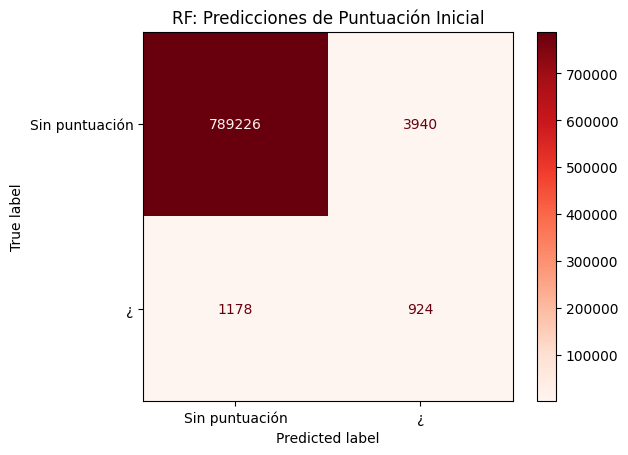

In [103]:
cm_ini = generate_confusion_matrix(
  y_test_true_ini, y_test_pred_ini, classes_ini, f"{model_name}: Predicciones de Puntuación Inicial", 
  f"{results_dir}{model_name}_ini_confusion_matrix.png"
)

### Métricas - Decisiones

In [104]:
generate_decision_metrics(cm_ini, classes_ini, f"{results_dir}{model_name}_ini_decision_metrics.txt")

Recall Sin puntuación: 0.9985096229270095
Recall ¿: 0.18996710526315788

Precision Sin puntuación: 0.9950325656924276
Precision ¿: 0.439581351094196

FPR Sin puntuación: 0.560418648905804
FPR ¿: 0.004967434307572438

F1 Sin puntuación: 0.9967680620370428
F1 ¿: 0.2652885443583118

F1 Macro: 0.6310283031976773
Accuracy: 0.9935644336248912
Balanced Accuracy: 0.5942383640950837



### Métricas - Scores

In [105]:
generate_scores_metrics(y_test_true_ini, y_test_proba_ini, classes_ini, f"{results_dir}{model_name}_ini_scores_metrics.txt")

AUC ROC OvR Sin puntuación: 0.8565067703367915
AUC ROC OvR ¿: 0.8565067724360756

Average Precision OvR Sin puntuación: 0.9992513597977547
Average Precision OvR ¿: 0.2227059234130056

Cross Entropy: 0.05759733058006192
AUC ROC OvR Macro: 0.8565067713864336
Average Precision Macro: 0.6109786416053802



## Puntuación final

### Input

In [106]:
df_test_fin = pd.read_csv('../data/processed/test_fin_rf_p.csv')

y_test_true_fin = df_test_fin["y_punt_fin"]
y_test_pred_fin = df_test_fin["y_pred"]
y_test_proba_fin = df_test_fin[["y_proba_0", "y_proba_1", "y_proba_2", "y_proba_3"]]

classes_fin = ["Sin puntuación", ',', '.', '?']

### Matriz de confusión

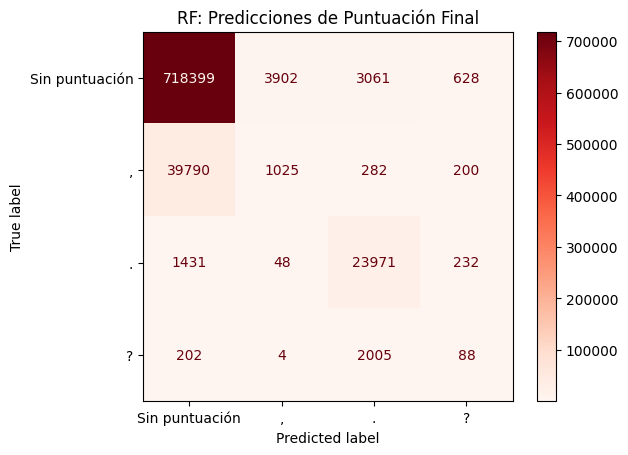

In [107]:
cm_fin = generate_confusion_matrix(
  y_test_true_fin, y_test_pred_fin, classes_fin, f"{model_name}: Predicciones de Puntuación Final", 
  f"{results_dir}{model_name}_fin_confusion_matrix.png"
)

### Métricas - Decisiones

In [108]:
generate_decision_metrics(cm_fin, classes_fin, f"{results_dir}{model_name}_fin_decision_metrics.txt")

Recall Sin puntuación: 0.9454832842428884
Recall ,: 0.20586463145209882
Recall .: 0.8175926873358573
Recall ?: 0.07665505226480836

Precision Sin puntuación: 0.9895439331120264
Precision ,: 0.0248202048574957
Precision .: 0.9333774628144226
Precision ?: 0.03827751196172249

FPR Sin puntuación: 0.597924304974162
FPR ,: 0.005244233531528401
FPR .: 0.0069491908636591625
FPR ?: 0.0013367483470350038

F1 Sin puntuación: 0.967011977289186
F1 ,: 0.0442994208661077
F1 .: 0.871656878965837
F1 ?: 0.051058891789962285

F1 Macro: 0.48350679222777326
Accuracy: 0.9348835864136367
Balanced Accuracy: 0.5113989138239132



### Métricas - Scores

In [109]:
generate_scores_metrics(y_test_true_fin, y_test_proba_fin, classes_fin, f"{results_dir}{model_name}_fin_scores_metrics.txt")

AUC ROC OvR Sin puntuación: 0.8688387949919105
AUC ROC OvR ,: 0.7859575836241822
AUC ROC OvR .: 0.9786529318145041
AUC ROC OvR ?: 0.7154495177033916

Average Precision OvR Sin puntuación: 0.9829994920046742
Average Precision OvR ,: 0.13793706680630538
Average Precision OvR .: 0.8316511666947253
Average Precision OvR ?: 0.0230100299836684

Cross Entropy: 0.4323679773855718
AUC ROC OvR Macro: 0.8372247070334972
Average Precision Macro: 0.49389943887234333



## Gráficos

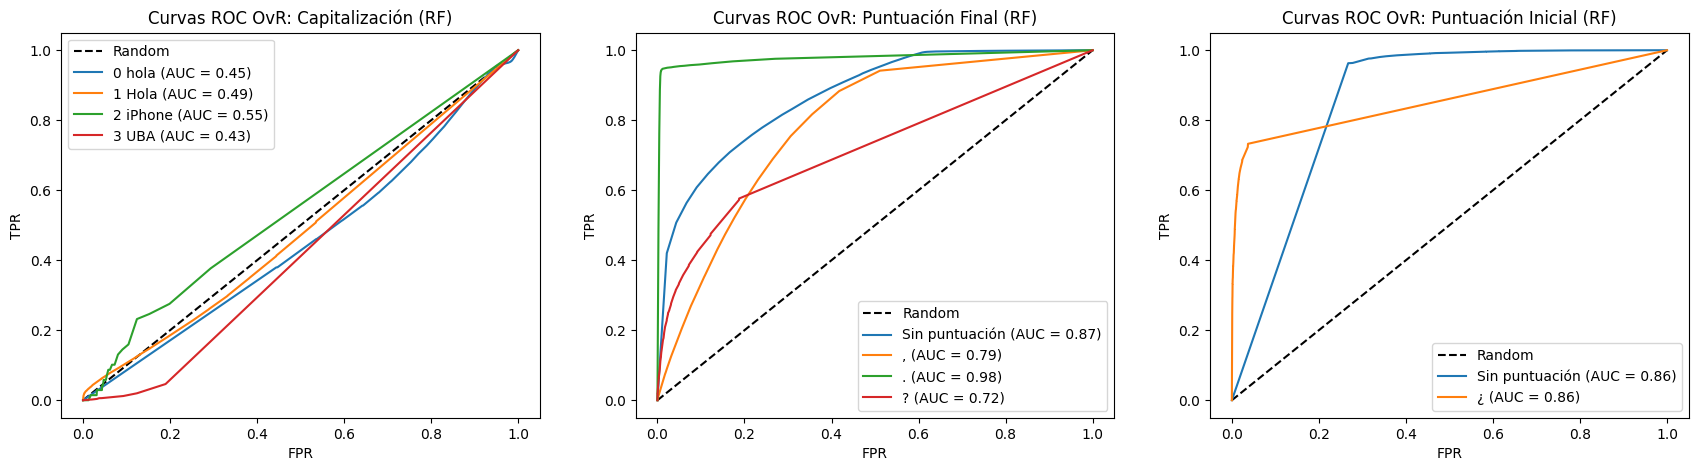

In [110]:
fig, ax = plt.subplots(1, 3, figsize=[21, 5])
graficar_roc_curves(y_test_true_cap,  y_test_proba_cap, classes_cap, f"Curvas ROC OvR: Capitalización ({model_name})", f"{results_dir}{model_name}_cap_auc_roc.png", ax=ax[0])
graficar_roc_curves(y_test_true_fin,  y_test_proba_fin, classes_fin, f"Curvas ROC OvR: Puntuación Final ({model_name})", f"{results_dir}{model_name}_fin_auc_roc.png", ax=ax[1])
graficar_roc_curves(y_test_true_ini,  y_test_proba_ini, classes_ini, f"Curvas ROC OvR: Puntuación Inicial ({model_name})", f"{results_dir}{model_name}_ini_auc_roc.png", ax=ax[2])

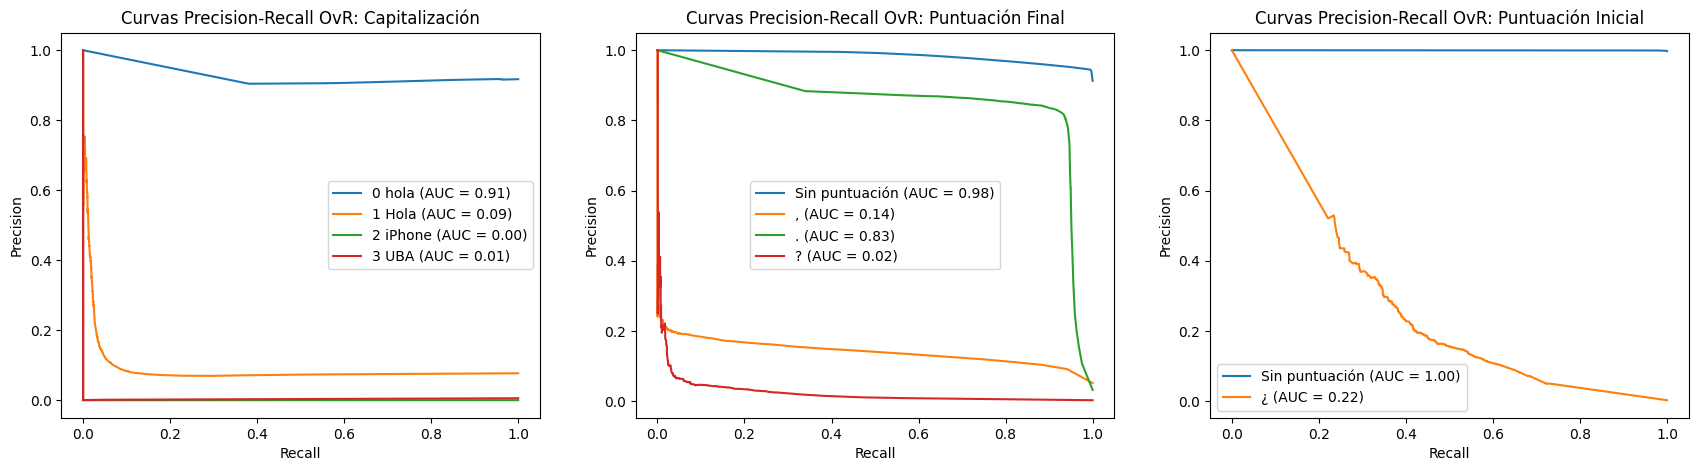

In [111]:
fig, ax = plt.subplots(1, 3, figsize=[21, 5])

graficar_precision_recall_curve(y_test_true_cap, y_test_proba_cap, classes_cap, "Curvas Precision-Recall OvR: Capitalización", f"{results_dir}{model_name}_cap_auc_pr.png", ax=ax[0])
graficar_precision_recall_curve(y_test_true_fin, y_test_proba_fin, classes_fin, "Curvas Precision-Recall OvR: Puntuación Final", f"{results_dir}{model_name}_fin_auc_pr.png", ax=ax[1])
graficar_precision_recall_curve(y_test_true_ini, y_test_proba_ini, classes_ini, "Curvas Precision-Recall OvR: Puntuación Inicial", f"{results_dir}{model_name}_ini_auc_pr.png", ax=ax[2])